## Ejercicio 2:

### Se separaro el 90% de las imagenes para entrenar y el 10% para validacion, pero luego solo se implemento aumentado de datos a la parte de entrenamiento con la ayuda de Roboflow quedando 2361 imagenes de entrenamiento y 58 de validacion. Para el testeo decidi hacerlo con video de manera manual para no perder datos de imagenes que podrian usarse para entrenar


### El aumentado de datos que se llevo a cabo incluia:
Flip: Horizontal, Vertical <br>
90° Rotate: Clockwise, Counter-Clockwise, Upside Down <br>
Saturation: Between -12% and +12% <br>
Brightness: Between -10% and +10% <br>
Exposure: Between -5% and +5% <br>

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rqEEbQ3v07shQHxl51l0")
project = rf.workspace("tptruco").project("cards-wltoo")
version = project.version(1)
dataset = version.download("yolov9")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cards-1 in yolov9:: 100%|██████████| 4847/4847 [00:01<00:00, 3177.56it/s]


##Script que valida anotaciones y unifica los formatos


In [4]:
import os
import shutil
from PIL import Image

def create_directories():
    if not os.path.exists('/content/Cards-1/label_errors'):
        os.makedirs('/content/Cards-1/label_errors')

def load_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = [line.strip().split() for line in lines]
    return annotations

def validate_bounding_box(x_center, y_center, width, height):
    if (x_center - width / 2 < 0 or x_center + width / 2 > 1 or
        y_center - height / 2 < 0 or y_center + height / 2 > 1):
        return False
    return True

# Convertir anotaciones al formato YOLOv5
def convert_to_yolo_format(bbox):
    if len(bbox) == 11:
        # Extraer coordenadas de los vértices
        x1, y1 = float(bbox[1]), float(bbox[2])
        x2, y2 = float(bbox[3]), float(bbox[4])
        x3, y3 = float(bbox[5]), float(bbox[6])
        x4, y4 = float(bbox[7]), float(bbox[8])

        # Calcular centro, ancho y alto
        x_center = (x1 + x2 + x3 + x4) / 4
        y_center = (y1 + y2 + y3 + y4) / 4
        width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
        height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)

        # Devolver en formato YOLOv5
        return [bbox[0], str(x_center), str(y_center), str(width), str(height)]
    elif len(bbox) == 9:
        # Extraer coordenadas mínimas y máximas
        x_min, y_min = float(bbox[1]), float(bbox[2])
        x_max, y_max = float(bbox[5]), float(bbox[6])

        # Calcular centro, ancho y alto
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        # Devolver en formato YOLOv5
        return [bbox[0], str(x_center), str(y_center), str(width), str(height)]
    elif len(bbox) == 5:
        return bbox
    else:
        raise ValueError("Formato de anotación no reconocido.p")

def save_annotations(file_path, annotations):
    with open(file_path, 'w') as file:
        for annotation in annotations:
            file.write(' '.join(annotation) + '\n')

def main():
    create_directories()
    annotations_path = '/content/Cards-1/train/labels'
    images_path = '/content/Cards-1/train/images'

    for filename in os.listdir(annotations_path):
        if filename.endswith('.txt'):
            annotation_file = os.path.join(annotations_path, filename)
            image_file = os.path.join(images_path, filename.replace('.txt', '.jpg'))

            if not os.path.exists(image_file):
                print(f"Image file {image_file} does not exist.")
                continue

            annotations = load_annotations(annotation_file)

            valid_annotations = []
            errors_found = False

            for annotation in annotations:
                try:
                    if len(annotation) == 11:
                        converted_annotation = convert_to_yolo_format(annotation)
                        x_center, y_center, width, height = map(float, converted_annotation[1:5])
                    elif len(annotation) == 9:
                        converted_annotation = convert_to_yolo_format(annotation)
                        x_center, y_center, width, height = map(float, converted_annotation[1:5])
                    elif len(annotation) == 5:
                        x_center, y_center, width, height = map(float, annotation[1:5])
                        converted_annotation = annotation
                    else:
                        print(len(annotation))
                        raise ValueError("Formato de anotación no reconocido.y")

                    if not validate_bounding_box(x_center, y_center, width, height):
                        errors_found = True
                        break

                    valid_annotations.append(converted_annotation)
                except Exception as e:
                    print(f"Error processing annotation {annotation} in file {annotation_file}: {e}")
                    errors_found = True
                    break

            if errors_found:
                shutil.move(annotation_file, os.path.join('/content/Cards-1/label_errors', filename))
                shutil.move(image_file, os.path.join('/content/Cards-1/label_errors', os.path.basename(image_file)))
            else:
                save_annotations(annotation_file, valid_annotations)

if __name__ == '__main__':
    main()

0


##Viendo el Balanceo de datos

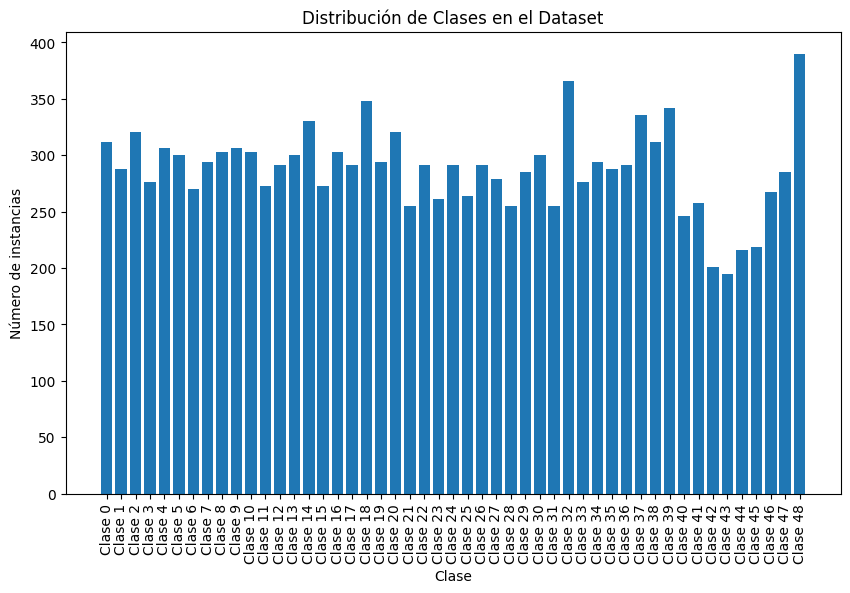

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_classes(yolo_labels_dir):
    class_counter = Counter()
    for label_file in os.listdir(yolo_labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(yolo_labels_dir, label_file), 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    return class_counter

yolo_labels_dir = '/content/Cards-1/train/labels'

class_counts = count_classes(yolo_labels_dir)

def plot_class_distribution(class_counts):
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Clase')
    plt.ylabel('Número de instancias')
    plt.title('Distribución de Clases en el Dataset')
    plt.xticks(ticks=list(class_counts.keys()), labels=[f'Clase {i}' for i in class_counts.keys()], rotation=90)
    plt.show()

plot_class_distribution(class_counts)

In [ ]:
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import yaml
import os

yaml_file_path = '/content/Cards-1/data.yaml'
new_yaml_file_path = '/content/Cards-1/dataset.yaml'

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

data['train'] = '/content/Cards-1/train/images'
data['val'] = '/content/Cards-1/valid/images'

with open(new_yaml_file_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("YAML actualizado.")

YAML file updated successfully.


In [ ]:
import fiftyone as fo
import fiftyone.utils.yolo as fouy

name = "Cards-1"

dataset_dir = "/content/Cards-1"

dataset_type = fo.types.YOLOv5Dataset

dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=dataset_type,
    name=name,
)
session = fo.launch_app(dataset)



 100% |███████████████████| 58/58 [320.5ms elapsed, 0s remaining, 189.0 samples/s] 


INFO:eta.core.utils: 100% |███████████████████| 58/58 [320.5ms elapsed, 0s remaining, 189.0 samples/s] 



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.24.1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|

